# Propensity scoring

TODO
*   Comparing propensity scoring to other causal methods, do we observe equivalent results?
*   Linear case - we can use an all features logistic regression
*   Baseline
    *   with no confounders
    *   with all features
*   Use propensity scores
    *   as a feature
    *   as inverse sample weights
    *   manual estimator
*   econml solution
*   Compare all results
*   Non linear - use a GBM to find P(T|X)
    *   Show that using all features with a linear model doesnt work
    *   Show that GBM based propensity scores with a linear model work

## Create dummy data

We create a data generating function to produce some dummy features with confounding and generate random outcomes from a linear model.

$P(T|X)$

In [2]:
import numpy as np
import pandas as pd


def print_results(array):
    print([f"{_x:.3f}" for _x in array])


def logit(p):
    return np.log(p) - np.log(1 - p)


def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))


def no_confound(x: np.array):
    return np.zeros(x.shape[0])


def linear_confound(x: np.array, a: float = 1.0, b: float = 0.5):
    return a * x[:, 0] + b


def generate_treatment_data(
    n_samples: int = 1000,
    n_features: int = 4,
    treatment_binary: bool = False,
    seed: int = None,
    confounding_fcn: callable = None,
    treatment_noise: float = 0.1,
):
    if confounding_fcn is None:
        confounding_fcn = no_confound

    rand = np.random.default_rng(seed)

    # generate random features
    x = rand.normal(
        loc=rand.normal(size=n_features),
        scale=rand.exponential(size=n_features),
        size=(n_samples, n_features),
    )

    t_x = confounding_fcn(x)
    if treatment_binary:
        t = rand.binomial(n=1, p=inv_logit(t_x), size=n_samples)
    else:
        t = treatment_noise * rand.normal(size=n_samples) + t_x

    x = np.concatenate([t[:, np.newaxis], x], axis=1)

    t_col = "t"
    x_cols = [f"x_{idx+1}" for idx in range(n_features)]

    return pd.DataFrame(data=x, columns=[t_col] + x_cols), t_col, x_cols


def generate_outcome_data(
    x: pd.DataFrame,
    outcome_binary: bool = False,
    outcome_noise: float = 0.1,
    seed: int = None,
    bias: float = None,
    weights: np.array = None,
):
    rand = np.random.default_rng(seed)

    n_samples, n_features = x.shape
    if bias is None:
        bias = rand.normal()
    if weights is None:
        weights = rand.normal(size=(n_features, 1))
    y = bias + np.dot(x, weights) + outcome_noise * rand.normal()

    if outcome_binary:
        y_avg = inv_logit(y)
        y = rand.binomial(n=1, p=y_avg, size=(n_samples, 1))
    else:
        y_avg = None

    return y, bias, weights, y_avg

## Propensity score

The propensity score is the probability of each row being within the treatment group.
The treatment in this case is binary.

Ref:
https://matheusfacure.github.io/python-causality-handbook/11-Propensity-Score.html

We start with the linear case.

We create data from a linear model where a linear regression model would be ideal.

We:
1. generate the data
2. fit a linear regression model with all the features and treatment
3. fit a linear regression model with only the treatment, ignoring the confounding features

In [36]:
import statsmodels.api as sm

# generate data
x_df, t_col, x_cols = generate_treatment_data(
    treatment_binary=True, confounding_fcn=linear_confound, seed=0
)
y, bias, weights, _ = generate_outcome_data(x=x_df, outcome_binary=False, seed=0)

print("True weights")
print_results(weights.flatten())

print("True treatment uplift")
print_results(weights[0])

True weights
['-0.132', '0.640', '0.105', '-0.536', '0.362']
True treatment uplift
['-0.132']


In [71]:
x_df

,t,x_1,x_2,x_3,x_4
0,1.0,-0.261565,-2.194666,0.220596,0.136114
1,0.0,-1.153834,-0.488722,-0.198802,-0.448182
2,0.0,-0.173799,-0.647655,0.917690,0.892312
3,1.0,0.054992,2.095149,0.192359,0.370396
4,1.0,0.622949,0.021130,0.139614,-0.591280
...,...,...,...,...,...
995,1.0,1.071486,-2.215251,0.563231,-0.040772
996,1.0,0.578116,-0.513351,0.451621,0.090621
997,1.0,-0.128852,0.764844,1.011599,-0.552608
998,0.0,0.594638,0.403959,0.561706,0.843759


Ignoring a confounder gives biased estimates of the treatment uplift.

In [50]:
print("True treatment uplift")
print_results(weights[0])

linear_model = sm.OLS(y, sm.add_constant(x_df[t_col])).fit()
print("Est treatment uplift, missing confounders, biased results:")
print_results(np.array(linear_model.params)[1:])
print(f"{linear_model.params[t_col]:.3f}")

True treatment uplift
['-0.132']
Est treatment uplift, missing confounders, biased results:
['0.056']
0.056


Model all features together

In [49]:
print("True treatment uplift")
print_results(weights[0])

linear_model = sm.OLS(y, sm.add_constant(x_df[[t_col] + x_cols])).fit()
print("Est treatment uplift")
print(f"{linear_model.params[t_col]:.3f}")

True treatment uplift
['-0.132']
Est treatment uplift
-0.132


## Fitting propensity scores
Predicting treatment allocation T given features X.

In [21]:
# fit models
t_model = sm.Logit(x_df[t_col], sm.add_constant(x_df[x_cols])).fit()
print("Est weights, all features:")
print_results(np.array(t_model.params)[1:])

t_prop = t_model.predict(sm.add_constant(x_df[x_cols]))
t_prop

Optimization terminated successfully.
         Current function value: 0.642029
         Iterations 5
Est weights, all features:
['0.794', '-0.019', '-0.181', '0.039']


0      0.576584
1      0.406237
2      0.562914
3      0.620872
4      0.722216
         ...   
995    0.785712
996    0.711037
997    0.546930
998    0.712151
999    0.756375
Length: 1000, dtype: float64

Diagnostics on propensity scores

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_97202/557473985.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<AxesSubplot: ylabel='Count'>

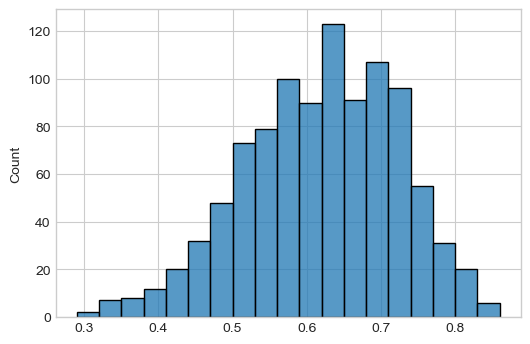

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(t_prop, ax=ax)

## Using the propensity scores

Using the propensity score as a feature

In [56]:
print("True treatment uplift")
print_results(weights[0])

linear_model = sm.OLS(
    y, sm.add_constant(np.stack([x_df[t_col], t_prop]).transpose())
).fit()
print("Est weights, all features:")
print_results(np.array(linear_model.params)[[1]])


True treatment uplift
['-0.132']
Est weights, all features:
['-0.130']


Using the propensity score as a sample weight
Inverse propensity scores

In [70]:
print("True treatment uplift")
print_results(weights[0])

linear_model = sm.WLS(
    y, sm.add_constant(np.stack([x_df[t_col]]).transpose()),weights=t_prop
).fit()
print("Est weights, all features:")
print_results(np.array(linear_model.params)[[1]])


True treatment uplift
['-0.132']
Est weights, all features:
['0.057']
